# Imports

In [14]:
!alias python==python3.8

In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 588.3 MB 33 kB/s s eta 0:00:01   |█▍                              | 25.3 MB 8.4 MB/s eta 0:01:07     |██                              | 37.4 MB 8.4 MB/s eta 0:01:06��███▊                        | 142.7 MB 28.3 MB/s eta 0:00:16     |██████████████                  | 255.7 MB 55.7 MB/s eta 0:00:06     |█████████████████               | 314.3 MB 46.0 MB/s eta 0:00:06�███████████████▎           | 373.8 MB 59.0 MB/s eta 0:00:04�███████████        | 440.6 MB 49.5 MB/s eta 0:00:03 eta 0:00:03MB/s eta 0:00:03��█████████████████████████   | 534.7 MB 83.0 MB/s eta 0:00:01�██ | 569.9 MB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 439 kB 34.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 39.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 36.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 48.6 MB/s eta 0:00:01�

In [4]:
!pip show tensorflow

In [15]:
!python --version

Python 3.9.5


In [19]:
!pip install 'tensorflow==2.3.0'

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==2.3.0


In [4]:
!pip show tensorflow

In [10]:
import torch
import math
import torch.nn as nn
import pandas as pd
import os, time, sys
import numpy as np
import seaborn as sns
import pytorch_lightning as pl
import h5py
sys.path.append(os.path.dirname(os.path.realpath('.')))
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as Func
from torchvision import transforms as T
from PIL import Image
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, roc_curve, confusion_matrix
import glob
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = 'svg'
pio.templates.default = 'plotly_white'
import cv2
from helpers.lightning_interface import *
from helpers.supernet import *
from helpers.xrai import *

In [11]:
from helpers.gradcam import NetworkGradCAM
import matplotlib as mpl
from skimage.transform import resize
import saliency.core as saliency

# Data Read In

In [12]:
DATA_DIR_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp_224_pandas/'
TEST_PATH = '/home/jmryan/private/DSC180/A/test/testdata.csv'
TRAIN_PATH = '/home/jmryan/private/DSC180/A/train/traindata.csv'
VAL_PATH = '/home/jmryan/private/DSC180/A/val/valdata.csv'

In [13]:
train_df = pd.read_csv(TRAIN_PATH, index_col=0)
val_df = pd.read_csv(VAL_PATH, index_col=0)
test_df = pd.read_csv(TEST_PATH, index_col=0)

In [14]:
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df[idx]
        filepath = row[2]  
        val = row[0]
        heart = row[1]
        im = torch.load(DATA_DIR_PATH + filepath)
        return im.view(1, 224, 224).expand(3, -1, -1), val, heart

In [15]:
train_dataset = PreprocessedImageDataset(df=train_df.to_numpy())
val_dataset = PreprocessedImageDataset(df=val_df.to_numpy())
test_dataset = PreprocessedImageDataset(df=test_df.to_numpy())

In [16]:
BATCH_SIZE = 32
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

# Model Load In

In [17]:
model = resnet152(weights=ResNet152_Weights.DEFAULT)

In [18]:
final_lin = [[2048, 4096], [4096, 2048], [2048, 512], [512, 256], [256, 1]]
net = SuperNet(layer_defs=None, linear_layers = final_lin, is_transfer=True, 
           model = model, lr_scheduler=True, lr = 1e-5, print_on = False)
net.load_state_dict(torch.load('presentation_figs/final_model'))
net.to('cuda');
net.turn_grad(True)

In [19]:
net.eval();

In [20]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = torch.movedim(torch.tensor(images), 3, 1).requires_grad_(True)
#     print(images.shape)
    
#     target_regression =  call_model_args[class_idx_str] ### NOT SURE
    
    outputs = net(images.to('cuda')).to('cpu')
    
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

In [21]:
for i in val_dl:
    break
images= i[0][0]

In [31]:
print(i[1][0])

tensor(3.2368, dtype=torch.float64)


In [34]:
images.shape

torch.Size([3, 224, 224])

In [35]:
net(images.view((1,3,224,224)).to('cuda'))

tensor([[2.7365]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
images.shape

torch.Size([3, 224, 224])

In [23]:
XRai = XRai(net)

In [24]:
XRai(images)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0705, 0.0740, 0.0752,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0626, 0.0538, 0.0444,  ..., 0.0000, 0.0000, 0.0000],
         [0.0630, 0.0525, 0.0455,  ..., 0.0000, 0.0000, 0.0000],
         [0.0607, 0.0523, 0.0474,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0705, 0.0740, 0.0752,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0626, 0.0538, 0.0444,  ..., 0.0000, 0.0000, 0.0000],
         [0.0630, 0.0525, 0.0455,  ..., 0.0000, 0.0000, 0.0000],
         [0.0607, 0.0523, 0.0474,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0705, 0.0740, 0.0752,  ..., 0.0000, 0.0000, 0.

array([[0.06759   , 0.06759   , 0.06759   , ..., 0.1245576 , 0.1245576 ,
        0.01847738],
       [0.06759   , 0.06759   , 0.06759   , ..., 0.1245576 , 0.1245576 ,
        0.1245576 ],
       [0.06759   , 0.06759   , 0.06759   , ..., 0.1245576 , 0.1245576 ,
        0.1245576 ],
       ...,
       [0.0648513 , 0.0648513 , 0.0648513 , ..., 0.10363574, 0.10363574,
        0.03833883],
       [0.0648513 , 0.0648513 , 0.0648513 , ..., 0.10363574, 0.10363574,
        0.03833883],
       [0.0648513 , 0.0648513 , 0.0648513 , ..., 0.10363574, 0.10363574,
        0.03833883]])

In [ ]:
images.shape

In [ ]:
net(images.to('cuda'))

In [ ]:
torch.movedim(images, 1, 3).shape

In [ ]:
preds = call_model_function(torch.movedim(images, 1, 3).numpy(), expected_keys = ['INPUT_OUTPUT_GRADIENTS'])

In [ ]:
preds['INPUT_OUTPUT_GRADIENTS'].shape

In [ ]:
preds['INPUT_OUTPUT_GRADIENTS'].shape

In [25]:
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(torch.movedim(images, 0, 2).numpy(), 
                                        call_model_function, batch_size=2)

In [26]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [27]:
# Boilerplate imports.
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import torch
from torchvision import models, transforms

# From our repository.
import saliency.core as saliency

In [ ]:
im.shape

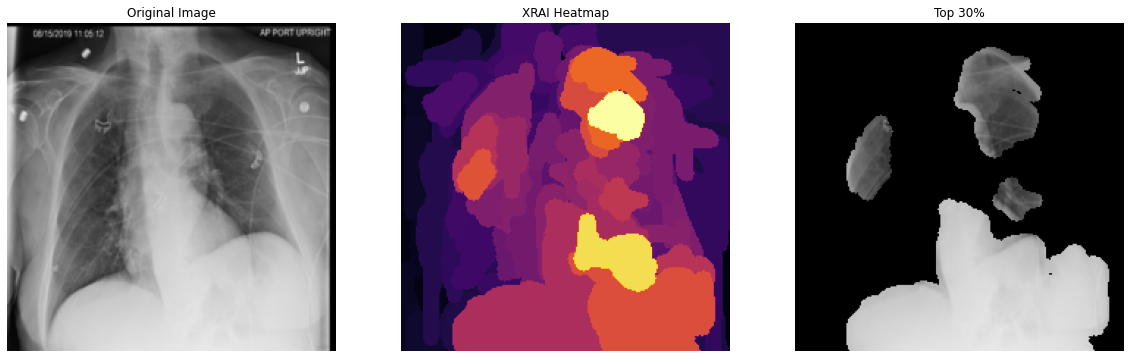

In [28]:
im = torch.movedim(images, 0, 2).numpy()
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
im_mask = np.array(im)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

In [ ]:
x_value = i[0][0]
x_baseline = [baselines[0]]
x_steps = 25
x_diff = x_value - x_baseline[0]

total_gradients = np.zeros_like(x_value, dtype=np.float32)

x_step_batched = []
for alpha in np.linspace(0, 1, x_steps):
    x_step = x_baseline + alpha * x_diff
    x_step_batched.append(x_step)

In [ ]:
preds['INPUT_OUTPUT_GRADIENTS'].shape

In [ ]:
preds.backward(retain_graph=True)
grads = gCAM.get_activations_gradient()

In [ ]:
grads.shape

In [ ]:
net.turn_grad(True)

In [ ]:
gCAM = NetworkGradCAM(net)

# set evaluation mode
gCAM.eval();